In [46]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from bs4 import BeautifulSoup
import requests
from PIL import Image, ImageChops
import urllib
import cv2
import io
import time
import glob
import random
print(tf.__version__)

2.0.0-beta1


In [79]:
IMAGE_SIZE = 160
NUM_OF_IMAGES_TO_DOWNLOAD = 5
NUM_OF_IMAGES = 10000


# Get Dataset

In [88]:
imagenet_categories = [("ship", "n04194289"),
                       ("people", "n07942152"),
                       ("kid", "n09918248"),
                       ("woman", "n10787470"),
                       ("school", "n04146050"),
                       ("stage", "n04296562"),
                       ("girlfriend", "n10130686"),
                       ("leader", "n03489162"),
                       ("house", "n03544360"),
                       ("center", "n02993546")]

### Fetching synset from imagenet

In [ ]:
soup_arr = []

for name, synset in imagenet_categories:
    page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=" + synset)
    # BeautifulSoup is an HTML parsing library
    # puts the content of the website into the soup variable, each url on a different line
    soup_arr.append(BeautifulSoup(page.content, 'html.parser'))
print(len(soup_arr))

In [ ]:
split_urls = []

for i in range(len(soup_arr)):
    #convert soup to string so it can be split
    str_soup=str(soup_arr[i])
    type(str_soup)
    #split so each url is a different possition on a list
    split_urls.append(str_soup.split('\r\n'))
    #print the length of the list so you know how many urls you have
    print(imagenet_categories[i][0] + " = " + str(len(split_urls[i])))

## Download Dataset

In [10]:
dataset_path = 'data'
os.makedirs(dataset_path, exist_ok=True)

In [62]:
#number of rows and columns to convert the images to
img_rows, img_cols = 32, 32 
#format to store the images (rows, columns,channels) called channels last
input_shape = (img_rows, img_cols, 3)

def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    imageBGR = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return imageBGR

In [71]:
# iterate over each category
for i in range(len(imagenet_categories)):
    category_urls = split_urls[i]
    print(len(category_urls))
    
    for progress in range(NUM_OF_IMAGES_TO_DOWNLOAD):
        # Print out progress whenever progress is a multiple of 20 so we can follow the
        # (relatively slow) progress
        if(progress%20==0):
            print('progress = ' + str(progress))
        
        if progress < len(category_urls) and not category_urls[progress] == None:
            try:
                downloaded_image = url_to_image(category_urls[progress])
                #check if the image has width, length and channels
                if (len(downloaded_image.shape))==3: 
                    #create a name of each image
                    save_path = dataset_path + '/img_' + imagenet_categories[i][0] + '_' + str(progress)+'.jpg'
                    cv2.imwrite(save_path, downloaded_image)
            except Exception as e:
                print("exception") 
                print(Exception)

1262
progress = 0
exception
<class 'Exception'>
exception
<class 'Exception'>
1432
progress = 0


KeyboardInterrupt: 

## Helper Functions

In [73]:
def load_img_to_np_array(image_path, show_image = False):
    raw_image = load_img(image_path)
    resized_image = raw_image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image_arr = img_to_array(resized_image)
    imaimage_arrge = np.array(image_arr, dtype=float)

    if (show_image):
        plt.figure()
        plt.imshow(resized_image)
        
#     print(resized_image)
#     print(image_arr.shape)
    return resized_image, image_arr

def convert_rgb2lab(image_arr):
    X = rgb2lab(1.0/255*image_arr)[:,:,0]
    Y = rgb2lab(1.0/255*image_arr)[:,:,1:]
    Y /= 128
    X = X.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
    Y = Y.reshape(IMAGE_SIZE, IMAGE_SIZE, 2)
    
#     print(X.shape)
#     print(Y.shape)
    
#     print(Y.min())
#     print(Y.max())
    
    return X, Y

def show_images(original, model_prediction, grayscale):
    
    plt.figure(figsize=(20,20))

    plt.subplot(3,3,1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original)
    plt.xlabel("original")

    plt.subplot(3,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(grayscale, cmap =plt.cm.gray)
    plt.xlabel("grayscale")

    plt.subplot(3,3,3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_prediction)
    plt.xlabel("rgb prediction")

    plt.show()
    
def predict(m_model, original_image, inputX):
    output = m_model.predict(inputX)
    output *= 128
    # Output colorizations
    cur = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
    cur[:,:,0] = inputX[0][:,:,0]
    cur[:,:,1:] = output[0]
    
    print(inputX.shape)
    print(output.shape)

    predicted_image = lab2rgb(cur)
    show_images(original_image, predicted_image, rgb2gray(predicted_image))
    
def load_and_preprocess_images(images_path, show_images=False):
    images_arr = []
    for i in range(len(images_path)):
        img, arr = load_img_to_np_array(images_path[i], show_image=show_images)
        
        if not is_greyscale(img):
            images_arr.append((img, arr))
            
    print(str(len(images_arr)) + " images were loaded successfully")
    return np.array(images_arr)

def convert_all_images_rgb2lab(images_arr):
    input_x = []
    output_y = []
    
    for image_arr in images_arr:
        in_x, out_y = convert_rgb2lab(image_arr[1])
        input_x.append(in_x)
        output_y.append(out_y)
    
    return np.array(input_x), np.array(output_y)

def is_greyscale(im):
    """
    Check if image is monochrome (1 channel or 3 identical channels)
    """
    if im.mode not in ("L", "RGB"):
        raise ValueError("Unsuported image mode")

    if im.mode == "RGB":
        rgb = im.split()
        if ImageChops.difference(rgb[0],rgb[1]).getextrema()[1]!=0: 
            return False
        if ImageChops.difference(rgb[0],rgb[2]).getextrema()[1]!=0: 
            return False
    return True


## Load dataset

In [81]:
train_images = list(glob.glob(dataset_path + '/*'))
train_images = [str(path) for path in train_images]
train_images = train_images[:NUM_OF_IMAGES]
print(len(train_images))
images_and_arrs = load_and_preprocess_images(train_images)

22
22 images were loaded successfully


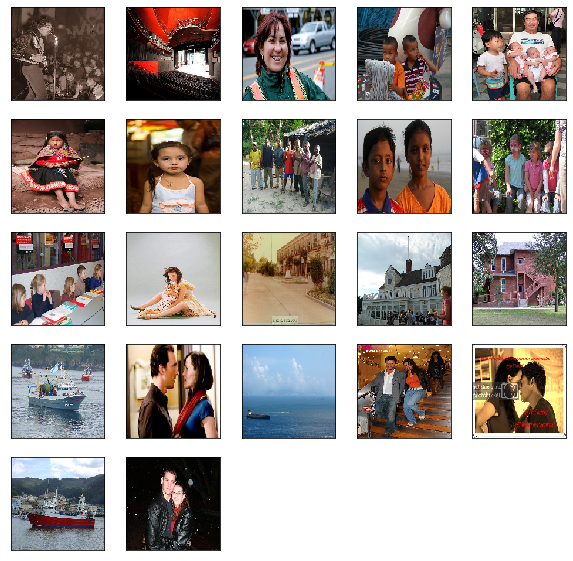

In [83]:
plt.figure(figsize=(10,10))
for i in range(25):
    if (i < len(images_and_arrs)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_and_arrs[i][0])
plt.show()

In [84]:
input_x, output_y = convert_all_images_rgb2lab(images_and_arrs)

print("input_x shape = " + str(input_x.shape))
print("output_y shape = " + str(output_y.shape))

for out_y in output_y:
    print(out_y.min())
    print(out_y.max())
    

input_x shape = (22, 160, 160, 1)
output_y shape = (22, 160, 160, 2)
-0.0030553167716193368
0.12334552686275851
-0.34262509086324416
0.6134251448019135
-0.3324825583564492
0.6733831765796253
-0.4458588004331303
0.5654598958414576
-0.2879957729042138
0.5802618902968592
-0.3962996053479256
0.6111791119871381
-0.15697884886114716
0.6927911939262225
-0.3887690879835261
0.5362772693858707
-0.2606837516103027
0.5538612308519817
-0.4055762980140102
0.6267944228826076
-0.40662904430164465
0.6166760042145827
-0.15081461238920096
0.5069936240930353
-0.10007231405570884
0.49115456173463806
-0.2057619795017087
0.40528870525204314
-0.4832214680373089
0.3512295320403502
-0.377879208598893
0.45089269144560695
-0.3284674793852491
0.4778603513500164
-0.26220267957289634
0.19796998037012353
-0.23727542593887835
0.5950727969194973
-0.17852263104636185
0.6041734092509573
-0.3876016228207902
0.3614582130928752
-0.21886758544037388
0.5397974765245788
